### imgtofmri: predicting group-average fMRI responses to visual stimuli

In this notebook we introduce `imgtofmri`, a python package that predicts group-average fMRI responses to individual visual frames. We are publicly releasing this package to aid research investigations into how brain responses are driven from visual stimuli, specifically individual image frames of movies. 

<!-- Intro temporal hierarchy -->
Neuroscience research has long investigated how humans are able to adeptly process continuous streams of immense perceptual data. Recent research has shown that brain responses to continuous and naturalistic stimuli, such as movies shown to participants in an MRI scanner, reveal temporal segmentation at timescales on the order of seconds to tens of seconds in high-level visual regions ([Baldassano et al. 2017](http://dx.doi.org/10.1016/j.neuron.2017.06.041)). Similar results have been shown with auditory cortex as well, such as with [Stephens et al. 2013](https://doi.org/10.1152/jn.00268.2013), where the authors analyze brain responses to auditory stories and observe a gradient of timescales across sensory regions, with early sensory regions demonstrating faster timescales (tens of milliseconds to seconds) and higher-level demonstrating longer timescales (tens of seconds). In fact, research has shown that even infants segment continuous information into discrete events at specific timescales, with [Yates et al. 2022](https://doi.org/10.1101/2021.06.16.448755) demonstrating stable brain activity in infants across the cortical hierarchy during long events. 
<!-- , although not showing the same gradient of shorter to longer timescales in infants as has been found in adults. -->

<!-- Process memory / TRW explanation -->
One possible explanation for these observed temporal dynamics could be due to the accumulation of information over time, with higher level regions showing stable brain responses over longer timescales as more information is processed. Recent theories such as the hierarchical process memory framework from [Hasson et al. 2015](http://dx.doi.org/10.1016/j.tics.2015.04.006) postulate that brain responses to sensory stimuli relies not only the current stimulus but also on past information at varying timescales. This theory builds on prior research showing that lower order sensory regions have shorter temporal receptive windows (TRW) on the order of milliseconds (e.g. to process phonemes), wheras higher order regions have TRWs on the order of seconds to minutes (e.g. to process a long sentence or paragraph) ([Honey, Christopher 2012](https://doi.org/10.1016/j.neuron.2012.08.011)). In this manner, the process memory framework might describe how the brain continuously integrates and accumulates present perceptual data with recent contextual information over varying timescales, and could explain why high-level sensory regions demonstrate stability over longer timescales.


<!-- Alternatively, these dynamics could be at least partly driven by dynamics in the stimulus itself (could try to cite something here about how natural stimuli have slowly-evolving topics, maybe this) https://www.nature.com/articles/s41562-021-01051-6
 -->
 
An alternative explanation to the long-timescale stability of high-level sensory regions could be that these temporal dynamics are, at least in part, due to dynamics inherent to the stimulus itself. Recent work such as [Heusser et al. 2021](https://doi.org/10.1038/s41562-021-01051-6) has sought to quantify the dynamics of content in naturalistic stimuli and narratives by using topic modelling and hidden Markov models (HMMs) to discretize continuous stimulus into events characterized by their trajectories through word-embedding space. In this manner, the authors compared participant recollection of a naturalistic stimulus to the original stimulus itself by comparing the geometric trajectories of their respective semantic content, and found that participants' recountings maintained the essential content, or trajectory, of the original narrative, but not fine-grained details. We might then suggest that the long-timescale stability in high-level sensory regions is at least in part due to the slower trajectories through semantic content inherent in narratives, and not purely due to accumulation of low-level information over time.

<!-- ###### (Process memory): -->
<!-- 
Memory buffers

Previous research focused on models of working memory that drew analogies from computer systems and described retrieval of memory from 'memory stores', such as those from a harddrive, where past information was thought to be integrated with present input through access to this working memory 'buffer' [[Baddeley 2012](https://doi.org/10.1146/annurev-psych-120710-100422)]. These theories, however, rely on several distinct memory components (mimicking a CPU, RAM, etc.) that have not been identified in the brain, and in fact, the neural regions often identified as the working memory 'buffers' are the same circuits that perform actual perceptual processing [[Buchsbaum, D'Esposito 2008](https://doi.org/10.1162/jocn.2008.20501)]. As a result of these challenges, more  
-->

<!-- Futhermore, this frame provides a foundation for describing how humans are able to use memories of , or schemas,  -->


<!-- ###### (Event boundary background): -->
<!-- This hierarchical process memory framework also extends well to the event segmentation literature, which uses the framework as a foundation for describing how humans use learned contexts and schemas to segment a constant stream of perceptual input into discrete events of varying timescales [[Zacks, Tversky 2001](http://dx.doi.org/10.1037//0033-2909.127.1.3); [Baldassano et al. 2017](https://doi.org/10.1016/j.neuron.2017.06.041)]. Research in this area has shown that these discrete events can be identified from cortical activity patterns and that the timescales of these events varies along a cortical hierarchy, with higher-order brain regions such as the posterior medial cortex showing longer timescales for events than sensory or early-visual regions [[Baldassano et al. 2017](https://doi.org/10.1016/j.neuron.2017.06.041)]. Movies are commonly used for studying this type of naturalistic perception within an fMRI scanner, and a result, research has focused on decoding semantic content from fMRI timecourse responses to natural movies [[Huth et al. 2016](https://doi.org/10.3389/fnsys.2016.00081)] (worth mention of study decoding what movie someone is watching based on HMM fit to events?). However, many questions remain about the timescale of events in these various brain regions, and about the extent to which these timescales can be predicted. -->

<!-- or predicting which movie someone is watching by just looking at their sequence of voxel-wise event boundaries, when fit to a machine learning model such as a hidden markov model -->


<!-- % have to motivate why f-f predictions are interesting to study -- this is a way to think ab movie responses and tease out current vs. past stimulus. -->
<!-- _Trim this down:_
Furthermore, given that neural circuits process both current perceptual information as well as past information, we would like to know what activity, at a given point of time, can be predicted solely based on current perceptual input. If we can better model cortical responses to current stimulus, disentangled from recent or past stimuli, we might better focus our attention to how cortical circuits integrate recent stimulus to process the present, separate from any specific present stimulus. Thus, if we could predict visuocortical responses to single frames of a movie, we could compare this expected stimulus-driven fMRI response to responses from humans actually watching that movie, and then analyze how much of their neural activity can be explained purely based on semantic and visual features of the current stimulus. In this manner, we hope our model can be used to tease apart neural responses to current input from neural responses to previous stimulus or context. 
 -->
<!-- - (more on modeling/prediction of events? -- maybe [[Reynolds 2010](https://doi.org/10.1080/15326900701399913)], [[Shin, Dubrow 2020](https://doi.org/10.1111/tops.12505)])

- (anything on animacy/object | big/small | many/few in visual processing hierarchy?) -->


<!-- ###### (DNNs as feature extractors for neural prediction): -->
<!-- -Our approach: characterize purely stimulus-driven dynamics using a frame-by-frame prediction model for visual cortex. Discuss the literature on DNN prediction (using the paragraph you already have)
 -->
Our approach to better understand this long-timescale stability in high-level sensory regions is to characterize the purely stimulus-driven dynamics in brain responses by using a frame-by-frame prediction model for visual cortex. We develop this prediction model using an artificial deep neural network (DNN), as DNNs have been shown promise (_reword?_) at predicting cortical responses in the human visual cortex when trained on real world visual categorization tasks ([Cichy et al. 2016](https://doi.org/10.1038/srep27755)). These neural networks learn to extract features (e.g. shapes, textures, eyes) from naturalistic visual data that allow them to accurately classify objects, animals, and scenes in the images they process ([Olah et al. 2017](https://distill.pub/2017/feature-visualization/)), and can also be used to extract those predominant features from input to be used in predicting brain responses along a cortical processing hierarchy ([Eickenberg et al. 2017](https://doi.org/10.1016/j.neuroimage.2016.10.001)). Research has also shown that the hierarchy of layers in a trained DNN can predict along a hierarchy of processing in the brain, where deeper, or higher, layers in a DNN best predict higher levels of cortical processing ([Kell et al. 2018](https://doi.org/10.1016/j.neuron.2018.03.044), [Schrimpf et al. 2020](https://doi.org/10.1101/407007)). 
Some models, as seen in [Khosla et al. 2021](https://doi.org/10.1126/sciadv.abe7547), use recurrences in their networks to better model the temporal integration of current information with recent information. We, instead, are not as interested in modeling the temporal integration of present and past stimuli, but instead are interested in modeling only the stimulus-driven responses to present input. As a result, we focus on predicting neural responses to single image frames, and then use the resulting event dynamics from our frame-by-frame predicted brains as comparison to temporally integrated human responses to the same stimulus. 
<!-- 
We also present a comparison of our model with a baseline luminance model, which describes the changes in lighting in image frames of the movie, to understand how the event dynamics of our predicted brains compares to event dynamics suggested purely based on changes in luminance throughout the movie. -->

<!-- Using DNNs for feature extraction and brain prediction has also been shown with other modalities, such as audio and language data [cite Huth] as well as  cross-modal audiovisual data [[Khosla et al. 2021](https://doi.org/10.1126/sciadv.abe7547)].  -->

<!-- ###### (Model introduction): -->

<!-- -Then list out the specifics of what we'll show in the notebook.
 -->


Here we present `imgtofmri`, a python package and model that allows for prediction of group-averaged cortical responses to visual stimuli. The model is built by combining a pretrained ResNet-18 DNN with a linear regression model to predict fMRI responses to individual images. The model is trained using data from the open source BOLD5000 project [[Chang et al. 2019](https://doi.org/10.1038/s41597-019-0052-3)], which provides us with the fMRI responses of three subjects viewing 4916 unique images. For each image, we predict into three visuocortical regions of interest (ROIs) in each subject's brain: the lateral occipital complex (LOC), which is commonly associated with object recognition, as well as the retrosplenial cortex (RSC) and the parahippocampal place area (PPA), which are both cortical regions involved in scene processing. 

In this notebook, we validate our model by predicting brain responses to unseen images from the twinset dataset ([Mohsenzadeh, 2019](https://doi.org/10.3390/vision3010008)) and we then demonstrate prediction of a continuous, naturalistic stimulus -- Pixar Animation Studio's Partly Cloudy. For more information on the training of our model using the open source BOLD5000 dataset and pretrained ResNet-18 DNN, we have included a notebook within our `model_training` folder that outlines this process and allows for extensions to other feature-detecting models.

## Model validation
We first show how we can use imgtofmri to predict fMRI responses to out-of-dataset images. We perform this on the [Twinset Dataset](http://twinsetfusion.csail.mit.edu/) compiled by Mohsenzadeh et al. This dataset is comprised of fMRI data for 15 adults viewing 156 images. These images can also be segmented into five categories: Scenes, Objects, Animals, Bodies, Faces

<center>
<img src="notebook_imgs/twinset_cropped.png" alt="drawing" width="300" align="center"/>
</center>

In [83]:
%load_ext autoreload
%autoreload 2
import imgtofmri
import analysis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, we download our validation dataset and define the directory to predict from:

In [10]:
import wget, zipfile

stimuli_url = 'http://wednesday.csail.mit.edu/fusion_rep/stimulus/156ImageStimuliSet.zip'
filename = wget.download(stimuli_url)

with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('input_images')

We are able to predict into five ROIs (EarlyVis, OPA, LOC, PPA, RSC), but by default we predict only into LOC, PPA, and RSC, as these three performed strongest above chance in our model training.

Here we define our input directory of images, and output directory to predict into:

In [11]:
input_dir = 'input_images/156ImageStimuliSet/'
output_dir = 'twinset_output/'

rois = ['LOC', 'PPA', 'RSC']

The `predict` function from imgtofmri is the main function of this package and takes in the input directory, output directory, and optionally ROIs to then produce a group-averaged fMRI brain for each image input. The function performs the following steps for every image in the input directory:
<ol> 
    <li> Pushes the image through our pretrained DNN and extracts its activations/features </li>
    <li> Predicts fMRI activity in each BOLD5000 subject's brain from those activations/features </li>
    <li> Transforms that subject's predicted brain into the MNI shared brain space </li>
    <li> Smooths the brain as a basic preprocessing step </li>
    <li> Averages the three predicted brains to form the group-averaged prediction</li>
</ol> 

The model then saves the brain volume for each image in the output directory using the same filename as each image file, with MRI file extension `.nii.gz`.

In [14]:
imgtofmri.predict(input_dir, output_dir, rois)

Averaging MNI brains: 100%|██████████| 157/157 [00:12<00:00, 12.15it/s]


### Twinset Analyses

First, we download the ground truth data from the twinset dataset, which we have lightly preprocessed by resampling each brain to MNI space, extracting our three ROIs of interest, and smoothing those responses with a sigma=1. This folder includes each subject's fMRI response to each of the 156 images as well as the average responses of all 15 individuals to those same images.

In [2]:
# TODO Code for downloading analysis data here

To evaluate our model's performance on a novel dataset, we compare our predicted fMRI responses to fMRI responses from human subjects, and evaulate the significance of our predictions against a null or chance distribution modeled using permutations. We construct our null distributions by taking the correlation matrix between our predicted and our actual, or 'real', human brains, and performing a number of shuffled permutations. We do this by shuffling the rows of the correlation matrix, and evaluating the difference between the mean of the diagonal and the mean of the off-diagonal. This is a proxy for evaluating how well our predicted brain of a specific image lines up to the actual brain of that specific image, and thus models the null distribution by seeing how many times a randomly permuted correlation matrix might produce a better correlation between the predicted and real brains.


In this manner, if our predictions are strong and well above chance, we expect that the difference between the diagonal and off-diagonal of our correlation matrix will be significantly higher when the matrix is properly aligned, with the predicted brains aligned with actual brains from the same image, as opposed to when we correlate our predicted brains with actual brains from a different image in the dataset. 

To perform this analysis, we first generate correlations between all pairs of predicted and actual brains (156 x 156), which will then be used in the shuffled correlation matrices in constructing our null distribution.

#### Group level analysis

In [ ]:
analysis.twinset_generate_group_correlations(image_dir=output_dir)

We then perform the actual permutations:

Performing permutation analysis: 100%|██████████| 10000/10000 [00:05<00:00, 1908.98it/s]


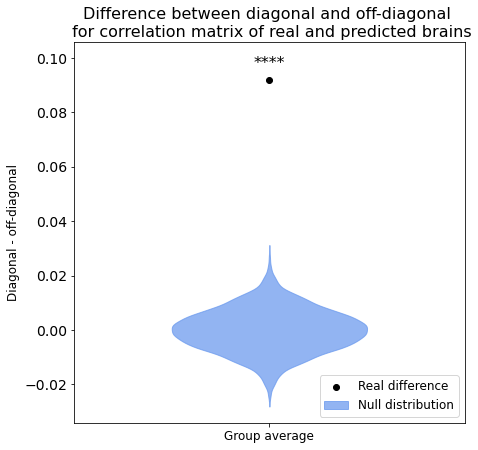

In [52]:
analysis.twinset_random_group_permutations(image_dir=output_dir, n_shuffle=10000, from_scratch=False)

Here we perform this analysis comparing our 156 predicted brains to the actual 156 brains viewing the same set of images, with each of those brains averaged in MNI space across the group of 15 individuals. We see that the difference between the diagonal and off-diagonal in our properly aligned matrix of predicted to real brains is significantly higher than the difference in the shuffled matrices in our null distribution. p-values are calculated here as (the number of shuffled differences greater than the real difference + 1) divided by (the number of resamples + 1).

Throughout this notebook, we use the following convention for significance indicators:
- † = <0.075
- \* = p < 0.05
- \** = p < 0.01
- \*** = p < 0.001, etc.

#### Category level analysis

Next, we perform the same analysis however consider each image as a part of one of the five twinset categories: animals, objects, scenes, people, or faces. In this manner, we can better understand how well our model predicts the fMRI responses to specific categories of visual stimulus. In this analysis, we still average each real or actual brain across all 15 subjects and correlate this averaged brain with all predicted brains to images within the same category.

We first generate all correlations within each category:

In [17]:
analysis.twinset_generate_category_correlations(output_dir)

Generating correlations for 'faces': 100%|██████████| 32/32 [00:18<00:00,  1.70it/s]


And subsequently permute null distributions through the same shuffling mechanism as previously explained:

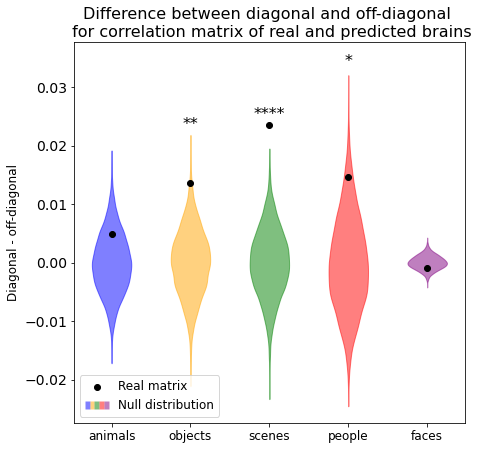

In [18]:
analysis.twinset_random_category_permutations(n_shuffle=10000)

From these results, we see that our predicted brains perform above chance in three of the five categories: objects, scenes, and people. We argue that our model performs strongest in these categories because they have the largest overlap with the BOLD5000 dataset used to train our model, which pulls its images from three computer vision datasets -- Scene UNderstanding (SUN) ([Xiao et al. 2010](https://doi.org/10.1109/CVPR.2010.5539970)), Common Objects in Context (COCO) ([Lin et al. 2014](https://doi.org/10.48550/arXiv.1405.0312)), and ImageNet ([Deng et al. 2009](https://doi.org/10.1109/CVPR.2009.5206848)). These images were chosen by the BOLD5000 authors to "cover the following image domains: real-world indoor and outdoor scenes; objects interacting in complex, real-world scenes; and objects centered in real-world scenes," so we find the high significance in the scene category to be validation of our model and its training set.

Additionally, we note that our model seems to not predict well into the animal and faces categories -- we argue that this is due to a lack of differentiation between images within these categories that our model can pick up. With faces in particular, we note that our DNN feature extractor was not trained on differentiating faces in any manner, and that we do not specifically predict into the fusiform face area (FFA)[note: should we check if LOC includes this area?], a cortical area heavily associated with face recognition and discrimination.

#### Participant level analysis

Our final validation analysis with the Twinset dataset investigates our model's prediction capabilities to each participant. Here we consider all 156 images per subject, and compare our predicted fMRI response to each subject's actual fMRI response.

We, again, first generate the participant correlations and then calculate the permutations:

In [19]:
# Note, this analysis may take a couple of hours if running from scratch
analysis.twinset_generate_participant_correlations(output_dir)

Generating correlations per participant: 100%|██████████| 2340/2340 [2:47:23<00:00,  4.29s/it]  


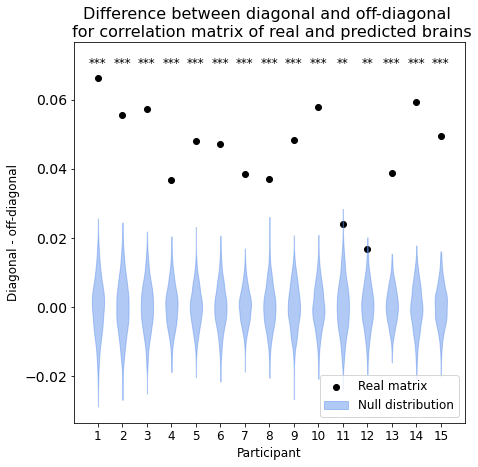

In [20]:
analysis.twinset_random_participant_permutations(n_shuffle=1000)

Here, we see that the diagonal - off-diagonal difference in the un-permuted matrices is significantly higher than the null distribution for all subjects. This suggests our model has predictive power within each subject, predicting well above chance which image a participant is viewing, from a set of 156.

## Extending our model to movies

In this final section, we extend our image prediction model to process movies, specifically to Pixar Animation Studio's Partly Cloudy, and compare our model to a baseline luminance model. In these analyses, in contrast to the twinset validation analyses, we do not explicitly compare our predicted fMRI responses to human fMRI responses on the voxel level, but instead compare self-correlation matrices to gauge how well our predicted reponses can model the local event structure present in the human brain. We thus compare how well our predicted brain responses represent the local coherence and similarity within events, observed in our human subjects, to a baseline luminance model whose correlation matrix represents how similar the luminance is across frames of the movie.

<!-- Perhaps good background?
Furthermore, given that neural circuits process both current perceptual information as well as past information, we would like to know what activity, at a given point of time, can be predicted solely based on current perceptual input. If we can better model cortical responses to current stimulus, disentangled from recent or past stimuli, we might better focus our attention to how cortical circuits integrate recent stimulus to process the present, separate from any specific present stimulus. Thus, if we could predict visuocortical responses to single frames of a movie, we could compare this expected stimulus-driven fMRI response to responses from humans actually watching that movie, and then analyze how much of their neural activity can be explained purely based on semantic and visual features of the current stimulus. In this manner, we hope our model can be used to tease apart neural responses to current input from neural responses to previous stimulus or context. 


After validating our model with this novel dataset, we then show how our model can be used to predict continuous fMRI responses to Pixar Animation Studio's Partly Cloudy and compare our model's frame-by-frame predictions to that of human subjects watching the same movie [[Richardson, 2018](https://doi.org/10.1038/s41467-018-03399-2)], showing that much of the event segmentation observed in the human brain can be explained by mid-level semantic information in the visual stimulus.
 -->

Due to copyright reasons we are unable to publicly release the Partly Cloudy movie used for predicting the fMRI responses. We have, however, provided utility functions which extend our `predict()` frame-by-frame fMRI prediction function to movies, as well as generate a correlation matrix of the baseline luminance measure. The following sequence of functions is used to predict fMRI responses to a movie:

- `extractFrames(movie_file, output_dir)`, which takes a movie and saves frames at a rate of 2Hz (to match the temporal resolution (TR) of the fMRI responses).
- `predict(input_dir, output_dir)`, which takes the frames from `extractFrames` and predicts an fMRI response for each frame to the `output_dir`
- `loadFrames()` *TODO function signature*, which loads the predicted frames into a 4D brain volume, representing voxel-level fMRI activity over time.

We then preprocessed the predicted brain response by convolving the response with a hemodynamic response function (HRF) and downsampling the frames to match the responses we have per TR  for our human fMRI data. We additionally performed a few preprocessing steps on both our predicted brain responses as well as the real brain responses from the twinset data: removing the average activity to focus on dynamics in responses over time, and removing stable activity over 2mins using a discrete cosine transformation (DCT), as stability at this timescale is likely an artifact. Lastly, we trimmed the response from our model to match the human data we have, which removes some of the introductory and ending credits. Information on these preprocessing steps can be found in our `appendix.ipynb`

We proceed with downloading: the predicted and preprocessed fMRI brain response to Partly Cloudy, the preprocessed and group-averaged real fMRI response to Partly Cloudy, and the frame-by-frame luminance correlation matrix.

In [ ]:
# download ground_truth/partly_cloudy info

In [21]:
import nibabel as nib
import numpy as np

In [ ]:
# # Predicting brain for movie from scratch requires having the Partly Cloudy movie as an 
# # m4v in this directory. (TODO: just wrap this into a predict_movie() function in imgtofmri.py

In [23]:
pc_dir = "data/partly_cloudy"
overlap = utils.get_subj_overlap()

In [78]:
# Loading predicted brain response to partly_cloudy
pred = nib.load(f'{pc_dir}/prediction_preprocessed.nii.gz').get_fdata()
pred = np.corrcoef(pred[overlap].T)

In [79]:
# Loading real brains, or, the actual group-averaged human fMRI response to Partly Cloudy
real = nib.load(f'{pc_dir}/real_group_avg_preprocessed.nii.gz').get_fdata()
real = np.corrcoef(real[overlap].T)

In [80]:
# Loading luminance 
# lum = utils.get_luminance(input_dir=frames_dir) # will only work if movie downloaded and frames have been extracted
lum = np.load(f'{pc_dir}/luminance_partly_cloudy.npy')
lum = np.corrcoef(lum)

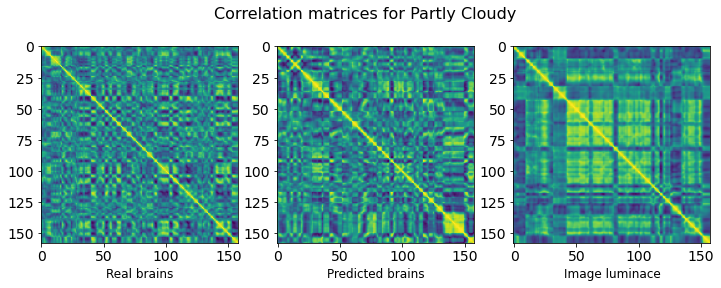

In [27]:
utils.plot_correlation_matrices(real, pred, lum)

Here we see the correlation matrices for the real, predicted, and luminance models, where coherence can be seen in regions with more yellow, and local dissimilarities, or lower pearson r values, can be seen in darker blue bands. For example, we can see the final TRs (after 150 TRs) show consistent responses across these three models as those image frames are the ending credits.

### Comparing performance between Predicted brains + Luminance model

To compare our predicted fMRI response to our baseline luminance model, we evaluate how closely each row of the real correlation matrix matches with the corresponding row in the predicted and luminance models. In this manner, at each timepoint in the movie we compare the correlation structure of our predicted brain responses and luminance model to the correlation structure of the real fMRI responses. Additionally, we perform this analysis 100 times, each time with a separate permutation of the 33 real brains, which is then used to generate a correlation matrix and subsequently used for this analysis.

In [ ]:
corr = imgtofmri.generate_bootstrapped_correlations(real, pred, lum, TR_band=None)

#### On the full movie timecourse

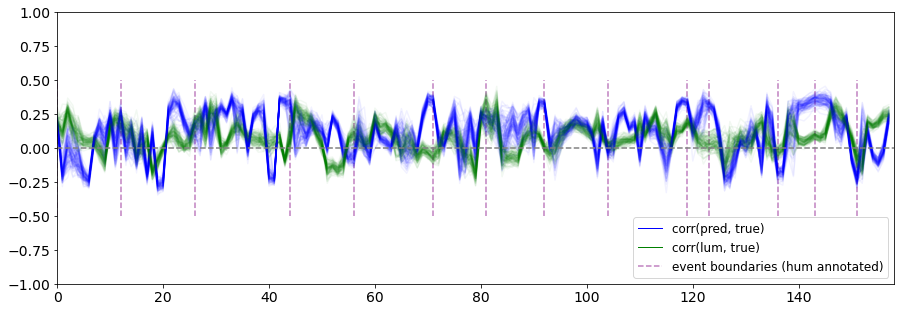

In [29]:
imgtofmri.pc_pred_lum_timecourse(corr)

Here we plot the correlation between rows of the predicted brain correlation matrix and the real group-averaged correlation matrix, as well as the correlation between rows of the luminance correlation matrix and the real group-averaged correlation matrix. As previously mentioned, this analysis is performed 100 times with a different group-averaged permutation of the 33 adult participants from [Richardson et al. 2018](https://doi.org/10.1038/s41467-018-03399-2). We show these results for all timepoints of the movie (158 TRs) and plot these correlations against human annotated event boundaries, which were collected from asking lab members to "watch this short silent film...and write down the timepoints (in minutes/seconds) of each place you think a meaningful segment of the movie has ended."

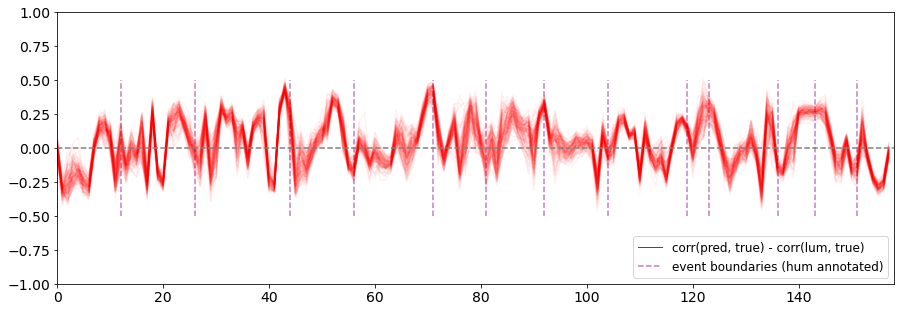

In [30]:
imgtofmri.pc_difference_timecourse(corr)

Here we plot the difference between the predicted to real correlation and the luminance to real correlation, for each of the 100 permutations of the real brains, demonstrating where our predicted fMRI response is better or worse than the luminance model. We notice that in several cases, a positive spike in the difference is seen around an event boundary -- something that we investigate further.

#### Boundary triggered averages with bootstraps

For our final analysis, we analyze how well our prediction model and the baseline model compare to the real fMRI responses around our human-annotated event boundaries by performing a boundary triggered average analysis. To conduct this analysis, we take 10 random resamples (with replacement) of our 13 human-annotated event boundaries, and average the correlations at each TR lag from the event boundary, skipping any TRs that are ±2 from another event boundary. Additionally, we perform this analysis for all 100 bootstraps of our real brain responses, resulting in 1000 samples considered for our boundary triggered average (though these parameters can be adjusted).

In [91]:
bound_averages = analysis.generate_boundary_triggered_averages(corr, num_boundary_bootstraps=10)

Generating bootstrapped boundaries: 100%|██████████| 1000/1000 [00:10<00:00, 96.19it/s]


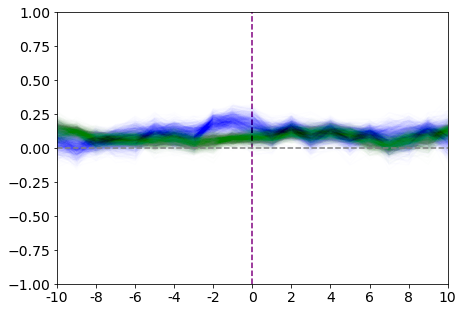

In [92]:
analysis.pc_bootstrapped_pred_lum(bound_averages)

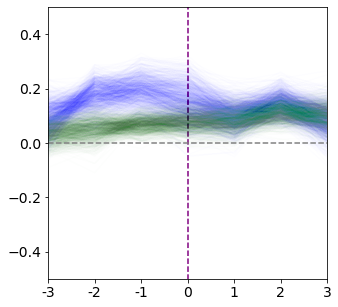

In [93]:
analysis.pc_bootstrapped_pred_lum_3TRs(bound_averages)

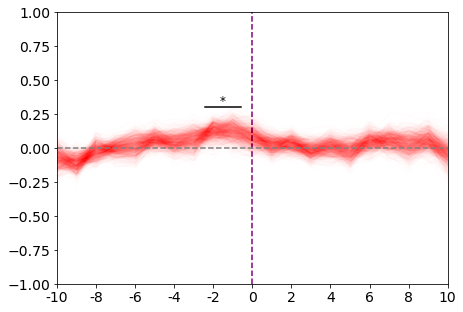

In [94]:
analysis.pc_bootstrapped_difference(bound_averages)

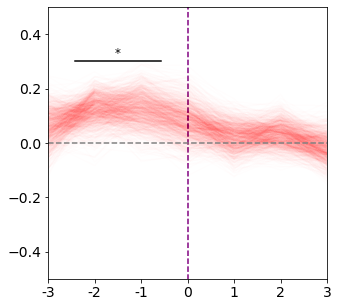

In [95]:
analysis.pc_bootstrapped_difference_3TRs(bound_averages)

Here, we see that in the two TRs prior to an event boundary, we see a significant difference between our predicted response and our real responses, suggesting that our predicted brain response more closely models the kind structure we see in the real fMRI response than the luminance model.

TODO: Figure out exactly how to speak on the slight asterisk changes in each run... E.g. from -2 TRs swithching between ** and *.

## Discussion